#Creating a better, more realistic chatbot using machine learning

In our last notebook, we looked at ELIZA, one of the first chatbots ever created, and we designed our own version of ELIZA. 

As you probably saw, the chatbot that we created was OK, but it definitely wasn't as good as something like Alexa or Siri. What's the next step that we can take to make our chatbot look more like something that we'd see today?

In this notebook, we'll explore how to use sequential neural networks for our chatbots, in order to improve their functionality and make them more realistic.

Before we start, here are a set of [slides](https://docs.google.com/presentation/d/1ykLNZNkql0SDqqDiNLKJVspUFhVLKB_7x-uB7sSlbNI/edit?usp=sharing) on NLP that might be a useful resource to go over, to make sure that we have some of the prerequisite background knowledge necessary for our project. 

![link](https://hackernoon.com/hn-images/1*5zQ_G4mZhB-4q-V9PhI0xQ.jpeg)

###Outline

This'll be the outline of our notebook for today!

1. Exploring our language data
2. From language to information: preprocessing methods
2. Modeling our data with a sequential neural network (RNN/LSTM)
4. Evaluation -- so how's our chatbot looking?
5. **Challenge**: Deep dive into the inner workings of the LSTM

In [ ]:
#@title Run this code to get started! This'll load some packages and set up some dependencies for us
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers , activations , models , preprocessing, utils
from keras import Input, Model
from keras.activations import softmax
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.text import Tokenizer
tf.random.set_seed(1)
from google.colab import drive
import time
import os
import gdown

# set pandas viewing options
pd.set_option("display.max_columns", None)
pd.set_option('display.width', None)
pd.set_option("max_colwidth", None)
#pd.reset_option("max_colwidth")

# the source of our data is: https://github.com/nbertagnolli/counsel-chat

# load our weights
#gdown.download('https://drive.google.com/uc?export=download&id=1212a1k_GxYbvh-CKF6m9oLwAb_ZBRkZe','chatbot_seq2seq_v3.h5',True);
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Mental%20Health%20Chatbots/chatbot_seq2seq_v3.h5'


--2022-02-26 04:59:29--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Mental%20Health%20Chatbots/chatbot_seq2seq_v3.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44061792 (42M) [application/octet-stream]
Saving to: ‘chatbot_seq2seq_v3.h5.1’

chatbot_seq2seq_v3. 100%[===================>]  42.02M   224MB/s    in 0.2s    

2022-02-26 04:59:29 (224 MB/s) - ‘chatbot_seq2seq_v3.h5.1’ saved [44061792/44061792]



## Preparing our dataset

We are going to be working with data from CounselChat (https://counselchat.com/), which is an online resource where people can ask questions and get answers from licensed mental health counselors. We are going to take a look at some of the questions that people asked on this site, see what the counselors responded with, and create a chatbot that'll try to do the same thing.

[**TW:** suicidal ideation] 

**Disclaimer**: This dataset was made freely available and all data was provided consensually, and in anonymized form. When working with sensitive data such as medical data, you should *always* get permission first!


In [ ]:
#@title Run this cell to download our dataset
chat_data = pd.read_csv("https://raw.githubusercontent.com/nbertagnolli/counsel-chat/master/data/20200325_counsel_chat.csv")


###Exploring our data

We should begin by getting a sense of what data we are working with. Our data is in a pandas dataframe named `chat_data`.

**Exercise**: Print out the first 5 rows in the dataset.

In [ ]:
## YOUR CODE HERE
chat_data.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to everyone?,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?",https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,"Sherry Katz, LCSWCouples and Family Therapist, LCSW",https://counselchat.com/therapists/sherry-katz-lcsw,"If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today.",1,2899,train
1,1,0,Can I change my feeling of being worthless to everyone?,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?",https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in a Primary Care Setting",https://counselchat.com/therapists/robin-landwehr-dbh-lpcc-ncc,"Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to r

**Question**: Which columns correspond to the question that the person asked? Which columns correspond to the answer that the mental health counselor gave?

Now, let's see how many questions and answers there are in each topic!

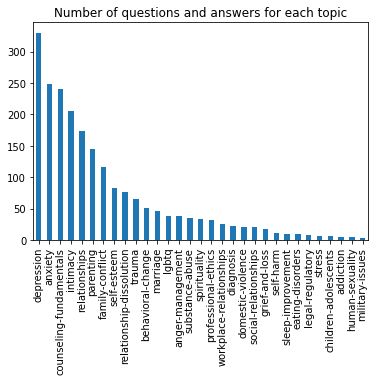

In [ ]:
#@title Run this cell to plot the number of questions and answers for each topic

chat_data["topic"].value_counts().plot.bar()
plt.title("Number of questions and answers for each topic")
plt.show()

**Question**: Which topics are most popular? Which topics are least popular? Why do you think that is?

**Question**: Why might there be bias towards / against certain topics in this dataset?

**Note**: As usual, remember to be kind and empathetic toward your fellow classmates! This may be a personal topic for some.

We want to train our chatbot to respond to users' questions with answers, in a similar fashion to how mental health counselors respond to people's questions on CounselChat. First, let's extract just the data we need for our model.

**Exercise**: What should the `X` be for our model? What should the `y` be? Fill in the code below with the necessary columns of our dataset.

In [ ]:
# YOUR CODE HERE:
X = chat_data["questionTitle"] # TODO: replace None with the columns we should assign to X
y = chat_data["answerText"] # TODO: replace None with the columns we should assign to Y

###Cleaning our data

We have our data now! But as you've probably noticed we have *language* data. A computer doesn't understand what language data means; to a computer, a word is just a bunch of letters. We need to figure out a representation for our language data such that our computer can understand it.

**Question**: How can we transform our language data into something that our machine learning algorithm can work with?

This question is the core of **natural language processing** (NLP)!

As a first step, we need to clean our data and get rid of some stuff that we don't want to see. We'll use **regular expressions** to do this. Regular expressions are a powerful tool that perform *pattern matching*, allowing us to search a piece of text for patterns and replace all occurrences of a pattern with something else.

For example, suppose we want to remove all occurrences of the letter "X" from a block of text (for whatever reason). This is the same as replacing the letter "X" with the empty string "". We can use the function `re.sub` to do this in Python:

```
text = re.sub(r"X", "", text)
```

**Question**: What are the arguments that we need to pass in to `re.sub`?

**Exercise**: Use the function `re.sub` to get rid of all occurrences of "\n" and all occurrences of "\xa0" from our data. For context, these are both forms of whitespace which clog up our data unnecessarily.




In [ ]:
def preprocess_text(phrase): 
  phrase = re.sub(r"\xa0", "", phrase) # YOUR CODE HERE: get rid of "\xa0"
  phrase = re.sub(r"\n", "", phrase) # YOUR CODE HERE: get rid of "\n"
  phrase = re.sub("[.]{1,}", ".", phrase) # removes duplicate "."s
  phrase = re.sub("[ ]{1,}", " ", phrase) # removes duplicate spaces

  return phrase

Now, run this next code cell to use your function to clean up our text!

In [ ]:
X = X.apply(preprocess_text)
y = y.apply(preprocess_text)

Now that we've cleaned up our text, let's see how many sentences long each person's question is and how many sentences long each therapist's response is.

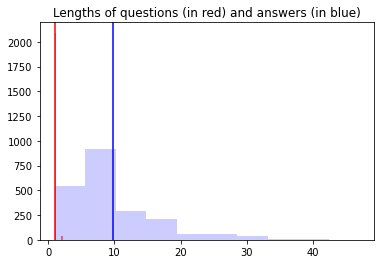

In [ ]:
#@title Run this cell to plot the lengths of questions and answers, in sentences
question_lengths, answer_lengths = [], []

for (question, answer) in zip(X, y): 
  # split by "."
  question_arr = question.split(".")
  answer_arr = answer.split(".")

  # get length
  length_question = len(question_arr)
  length_answer = len(answer_arr)

  # add to array
  question_lengths.append(length_question)
  answer_lengths.append(length_answer)

# Display the plot
plt.hist(question_lengths, color = "red", alpha = 0.5)
plt.hist(answer_lengths, color = "blue", alpha = 0.2)
plt.title("Lengths of questions (in red) and answers (in blue)")
plt.axvline(np.mean(question_lengths), color = "red")
plt.axvline(np.mean(answer_lengths), color = "blue")
plt.show()

####Discussion

1. In the plot above, what do the red bars indicate? What do the blue bars indicate?
2. The vertical lines in the plot above indicate average lengths. What is the average length of a question? What is the average length of an answer?
3. Do people's questions or therapists' responses tend to be longer? Why might this be the case? How do you think this might affect our chatbot?

### Splitting up our questions and answers

There's a little more preprocessing we need to do however! We want to keep our phrases relatively short; however, some of the questions and answers in our dataset are several sentences long.

To solve this problem, we'll split up each question and each answer into their constituent sentences. We'll then pair the first sentence of the question with the first sentence of the answer, the second sentence of the question with the second sentence of the answer, and so on until we can't form any more pairs.

For example, suppose we have the following question-answer pair:
> **Q**: "I am not feeling well today. I feel sad."

> **A**: "Tell me more about how you feel. What have you been up to today?"

First, we would split up the question into its constituent sentences, resulting in `["I am not feeling well today.", "I feel sad."]`. Similarly, we would split up the answer into its constituent sentences, resulting in `["Tell me more about how you feel.", "What have you been up to today?"]`. Finally, we would pair each sentence of the question with its corresponding sentence of the answer, ultimately resulting in two separate question-answer pairs:
> **Q**: "I am not feeling well today."

> **A**: "Tell me more about how you feel."

and

> **Q**: "I feel sad."

> **A**: "What have you been up to today?"

**Exercise**: Fill in the missing code blocks in the following cell to loop through each question and answer pair, split up each question and answer into their constituent sentences, and pair up each sentence of the question with its corresponding sentence of the answer.

**Hint**: To split text, check out the `split` function.





In [ ]:
question_answer_pairs = []

MAX_LENGTH = 100 # the maximum length for our sequences

for (question, answer) in zip(X, y):
  question = preprocess_text(question) 
  answer = preprocess_text(answer)

  # split up question and answer into their constituent sentences

  question_arr = question.split(".") ## YOUR CODE HERE
  answer_arr = answer.split(".") ## YOUR CODE HERE

  # get the maximum number of question/answer pairs we can form,
  # which will be the shorter of len(question_arr) and len(answer_arr)

  max_sentences = min(len(question_arr)), len(answer_arr)) ## YOUR CODE HERE

  for i in range(max_sentences):
    q_a_pair = []

    # get maximum sentence length
    max_q_length = min(MAX_LENGTH, len(question_arr[i]))
    max_a_length = min(MAX_LENGTH, len(answer_arr[i]))

    # append question, answer to pair (e.g,. first sentence of question + first sentence of answer, etc.)
    question_to_append = question_arr[i][0:max_q_length]
    q_a_pair.append(question_to_append)

    answer_to_append = "<START> " + answer_arr[i][0:max_a_length] + " <END>"
    q_a_pair.append(answer_to_append)

    question_answer_pairs.append(q_a_pair)

SyntaxError: ignored

###Tokenizing our data

Now that we've preprocessed our text, let's start turning it into a form that our machines can interpret. **Tokenization** is the process of turning our sentences into a list of individual tokens, like words. For example:

1. Pre-tokenization: "Hello, I really like computers"
2. Post-tokenization: ["Hello," , "I", "really", "like", "computers"]

**Question**: How can we tokenize sentences?

**Exercise**: Write a function to tokenize sentences.

In [ ]:
def tokenize(sentence):
  

  ## BEGIN YOUR CODE HERE
  tokens = sentence.split(" ")
  ## END YOUR CODE HERE

  return tokens

In [ ]:
#@title Enter a sentence to test your tokenization function

sentence = "I love Inspirit AI!" #@param {type:"string"}

# split sentence by space
split_sentence = tokenize(sentence)
print(f"The original sentence: {sentence}")
print(f"The tokenized sentence: {split_sentence}")

The original sentence: I love Inspirit AI!
The tokenized sentence: ['I', 'love', 'Inspirit', 'AI!']


###Padding our data

For our neural network model to work, our input sentences must all be of the same length. However, as we've seen, some sentences are longer than others! Our sentences need to be all the same length, but some sentences are longer than others.

So what can we do? If a sentence is too long, we will trim it. If a sentence is too short, we'll add some **padding tokens**.

We also need to add **start tokens** and **end tokens**, which tell our program when a sentence is starting and ending respectively.

**Question**: Why do we need start and end tokens? (Hint: consider what might happen if a sentence is too long and is trimmed!)

####Example

Let's run through how we might pad an example sentence. Suppose we have:

`"This is a really cool sentence!"`

First, we add our start and end tokens, which we represent with `"<SOS>"` and `"<EOS>"`:

`"<SOS> This is a really cool sentence! <EOS>"`

Suppose we want sentences to be 10 tokens long. Since our sentence is only 8 tokens long, we need to we add padding tokens, which we represent with `"<pad>"`:

`"<SOS> This is a really cool sentence! <EOS> <pad> <pad>"`

Alternatively, suppose we wanted sentences to be 6 tokens long. Then, we would trim our sentence (note: keep the \<EOS\>!):

`"<SOS> This is a really <EOS>"`

**Exercise**: Fill in the missing code blocks in the function below to add these features to our sentence data.

In [ ]:
def tokenize_and_pad(sentence, max_len):
  """
    Tokenizes our sentence (splits up the individual words), adds <SOS> and <EOS> tags, 
    and, if it's too short, add, padding at the end (before <EOS>)
  """

  sentence_arr = tokenize(sentence)

  diff = max_len - (len(sentence_arr) + 2)

  if diff > 0: # if too short, add padding + start/end tokens
    ## BEGIN YOUR CODE HERE
    tokenized_sentence = ["<SOS>"] + sentence_arr + ["<EOS>"] + (["<pad>"] * diff)
    ## END YOUR CODE HERE
  elif diff == 0: # if right length, just add start/end tokens
    ## BEGIN YOUR CODE HERE
    tokenized_sentence = ["<SOS>"] + sentence_arr + ["<EOS>"] 
    ## END YOUR CODE HERE
  else: # if too long, add start/end tokens, truncate
    ## BEGIN YOUR CODE HERE
    tokenized_sentence = ["<SOS>"] + sentence_arr[0:diff] + ["<EOS>"] 
    ## END YOUR CODE HERE

  return tokenized_sentence
  

In [ ]:
#@title Run this code chunk to see your function at work! Enter a sentence and a maximum length and see how it looks when tokenized and given padding

sentence = "Hello from the other side! Hello from the other side!" #@param {type:"string"}
max_len =  10#@param {type:"integer"}

print(tokenize_and_pad(sentence, max_len))

['<SOS>', 'Hello', 'from', 'the', 'other', 'side!', 'Hello', 'from', 'the', '<EOS>']


Phew, that was a lot! Cleaning and preparing a dataset is one of the most important parts of creating a good machine learning model. After all, a good model is nothing without good data! Speaking of which, it's about time we begin designing our model....

##Modeling our data with a Sequential Neural Network

### Review: What are neural networks?

By now, you've had the chance to use regular **neural networks**! Neural networks are a machine learning model loosely modeled after the human nervous system. They are commonly used for a variety of tasks, such as facial recognition, language generation, stock prediction, and more!

Neural networks operate by stacking layers and layers of **neurons**, each of which detects a portion of the input. However, there are some problems with traditional neural networks that we run into when trying to use them for natural language processing.

![link](https://cdn.kastatic.org/ka-perseus-images/53bcace05b8a222f57f0c07f86f92354c4614d01.svg)

For example, let's take a look at the above neural network.

**Question**: First of all, what does this model assume about the length of the input text? What about the length of the output text?

**Question**: Word order matters. For example, "man ate chicken" and "chicken ate man" are quite distinct! Furthermore, each word gives crucial information for the next one. Does this model capture those relationships?



###Recurrent Neural Networks

In order to resolve these problems, we must explore a different type of neural network, one that can handle *sequence data*, called a **recurrent neural network** (RNN).

![link](https://cdn-images-1.medium.com/freeze/max/1000/1*SKGAqkVVzT6co-sZ29ze-g.png?q=20)

RNNs are designed for sequence data: the model processes its input and products output *in order*.

So how do RNNs work?

In brief, as an RNN processes its input, it maintains a **hidden state vector** to remember some of what it's seen so far.

**Question**: For text generation, what should an RNN remember?

With each new input, the model uses the old hidden state to compute a new hidden state and a new output.

For this type of question, where we try to predict what comes next, based off of what came before it, RNNs work really well.

**Optional**: For another look into RNNs, check out [this Medium article](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce).

###Long-Short Term Memory Networks

For our notebook, we'll actually use a specialized type of RNN called a **long-short term memory network** (LSTM). An LSTM is typically more accurate than a basic RNN, especially for longer sequences, because it also maintains a form of *long-term memory* in addition to the *short-term memory* which an RNN maintains. Consequently, it is able to remember important pieces of information for a long period of time, whereas an RNN is only able to maintain information for a short period of time.

We won't go into the nitty-gritty of LSTMs since they are somewhat complex, but if you want a deeper understanding of LSTMs, please check out the Challenge Exercise portion of this notebook.

**Question**: Why is an RNN only able to maintain information for a short period of time? (hint: think about what happens to information stored in the hidden state vector as we continue writing to the hidden state vector!)

###The Seq2Seq model design

We'll put two LSTMs together to create our model, in a type of design called **Seq2Seq**. The Seq2Seq design is used in scenarios where one wants to model both what someone is telling the model and what the model should say in response. This allows the model to process the entire input before formulating a response, which is very useful for language data. This seems like a great model to use for our chatbot!

The Seq2Seq model design has two main components:
1. One LSTM which processes the input and encodes the information into word embeddings. We call this LSTM the **encoder**.
2. One LSTM which takes the word embeddings and decodes them into a response. We call this LSTM the **decoder**.

![link](http://4.bp.blogspot.com/-aArS0l1pjHQ/Vjj71pKAaEI/AAAAAAAAAxE/Nvy1FSbD_Vs/s1600/2TFstaticgraphic_alt-01.png)

### Creating our model

In [ ]:
#@title Run this cell to do some initialization

# re-create questions, answers
questions = [arr[0] for arr in question_answer_pairs]
answers = [arr[1] for arr in question_answer_pairs]

target_regex = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789'
tokenizer = Tokenizer(filters=target_regex)
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1

# create encoder input data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
#encoder_input_data = pad_sequences(tokenized_questions,
#                                   maxlen=maxlen_questions,
#                                   padding='post')

# create decoder input data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
#decoder_input_data = pad_sequences(tokenized_answers,
#                                   maxlen=maxlen_answers,
#                                   padding='post')

# create decoder output data
#for i in range(len(tokenized_answers)):
#    tokenized_answers[i] = tokenized_answers[i][1:]
#padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
#decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE)

**Exercise**: Fill in the missing code blocks in the cell below to complete the Seq2Seq model design.
 * First, we need to process our input through our encoder LSTM. In the first missing code block, create an `LSTM` layer with 200 units which returns the last state (`return_state=True`). Store this layer in `enc_lstm`.
 * Next, we need to process our embeddings through our decoder LSTM. In the second missing code block, create an `LSTM` layer with 200 units which returns the last state (`return_state=True`) *and* returns the last output (`return_sequences=True`). Store this layer in `dec_lstm`.
 * Finally, we want to run the output of our decoder through a fully connected neural network. In the third missing code block, create a `Dense` layer with `VOCAB_SIZE` units and a softmax activation function. Store this layer in `dec_dense`.

**Hint**: Check the Keras documentation for details on [the `LSTM` layer](https://keras.io/api/layers/recurrent_layers/lstm/) and for details on [the `Dense` layer](https://keras.io/api/layers/core_layers/dense/).

In [ ]:
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
enc_lstm = None ## YOUR CODE HERE
_, state_h, state_c = enc_lstm(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = None ## YOUR CODE HERE
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)

dec_dense = None ## YOUR CODE HERE
output = dec_dense(dec_outputs)

Great job! You've created a Seq2Seq model.

**Exercise**: Next, use `model.compile()` to compile your model with an `RMSprop` optimizer and a `categorical_crossentropy` loss function. Then print out a summary of your model using `model.summary()`.

**Hint**: Check the Keras documentation for [details on `model.compile`](https://keras.io/api/models/model_training_apis/#compile-method).

In [ ]:
model = Model([enc_inputs, dec_inputs], output)

## YOUR CODE HERE

In [ ]:
#@title Run this code chunk to do some clean-up
tf.keras.backend.clear_session()

###"Training" our model

Alright, our model is ready to go!

Normally, we would do training now. However, in our case, we'll use a pre-trained model instead. If we were to train our model from scratch, it would take *waaaay* too long to train -- much longer than we have classtime for!

For this reason, it is typical for large tech companies with more resources to train models such as Seq2Seq on large amounts of data and then release the weights of their trained models to the public. Then others, such as ourselves, can take these trained models, train just a couple layers on top of them to learn domain-specific knowledge, and then have a fully-functional model all trained and ready to go!

**Exercise**: Load a set of pre-trained weights into our model. To do this, you can use the function `model.load_weights()`.

**Hint**: As usual, check the Keras documentation for [details on model.load_weights](https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights).

In [ ]:
# The filepath to our pre-trained weights
path_to_weight = "chatbot_seq2seq_v3.h5"

## YOUR CODE HERE

## Evaluation -- so how's our chatbot looking?

Model designed, check. Model trained, "check". You've successfully created a fully-functional and fully-trained model -- awesome! All that's left to do now is test out our model and see how it does!

In [ ]:
#@title Run this cell to do some initialization
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                             initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')
    
enc_model, dec_model = make_inference_models()


In [ ]:
#@title Run this cell and type your question to see what our chatbot says!

question = "Could you give me some advice?" #@param {type:"string"}
for _ in range(1):
    states_values = enc_model.predict(
        str_to_tokens(question))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq]
                                              + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += ' {}'.format(word)
                sampled_word = word

        if sampled_word == 'end' \
                or len(decoded_translation.split()) \
                > maxlen_answers:
            stop_condition = True

        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    print(decoded_translation)

####Discussion

1. How did our pretrained model do? Do you think it's an improvement over our ELIZA chatbot from last notebook? Why or why not?
2. Are there some responses that surprise you?
3. Are there certain types of mistakes that the program keeps making? 
4. How do you think we can improve our program? As you can see, it's still definitely a work in progress, and we'll work on improving it in our next notebook. Can you think of some ways that we could go about trying to improve it?

Food for thought:
  - What would happen if we gave our chatbot more examples to learn from?
  - This program that we're using was trained for 100 epochs. Do you think that we should train it for longer? How long is long enough?
  - Should we use more neurons in our neural network and make it bigger?

###Conclusion

Congrats! Today, you've built an even better chatbot, one that's powered by artificial intelligence and machine learning. Hopefully you can see that our chatbot is looking a little bit more and more like the chatbots and voice assistants that we take for granted today, such as Alexa and Echo. You've learned about the key technologies that have driven modern chatbots; most of the current cutting-edge work in language generation and in chatbots is some improvement on the programs that you've learned about today. In our next notebook, we'll look at even more cutting-edge machine learning techniques in order to make our chatbots perform better, while also tying back our chatbot to our question of mental health and thinking about how well our chatbots would work in that context. Till next time!

###Challenge Exercise: How do LSTMs actually work?

#### Let's examine why LSTMs were created in the first place

Regular RNNs suffer from what's called a "vanishing gradient". What does this mean?

For example, if you gave an RNN two sentences with blanks:

1. "I loved traveling to France, where the weather was lovely and the food was extraordinary. I particularly enjoyed exploring the capital city of ____."

2. "I'm a person who just really enjoys traveling and trying all the good food around the world. The capital of France is _____."

Which one do you think a typical RNN would do better at predicting?

A typical RNN would do better with sentence (2) than sentence (1).

Why?

So here, the correct word for each of the blanks is "Paris", the capital of France. The key bit of information that you would've needed to see was the word "France". However, in sentence (1), France is in the beginning of the string, and the blank is at the end, while in sentence (2), France is near the blank. 

Typical RNNs place more weight on more recent information when trying to predict, say, what comes next. Functionally, this makes sense, since it's often likely that the information that helps predict what word comes next is probably the words that came just before it. However, there are definitely instances where we want our program to, say, remember what came up much earlier in a long conversation, and typical RNNs can't do that too well.

![link](http://images.memes.com/meme/721858)


LSTMs and GRUs are two similar models which are both modifications of RNNs that were designed to get around this problem. Below is a structure of an LSTM cell, which is the "fundamental unit" of an LSTM (similar to how the fundamental unit of a neural network is the neuron).

![link](https://i.stack.imgur.com/voZql.jpg)

The key takeaway here is that LSTMs can selectively "choose" what things to remember and what things to forget. 

Typical RNNs have one "hidden unit", which keeps track of, for example, what was said earlier in a sentence. However, this hidden unit can be heavily influenced by what it's seen more recently, and so things that were seen earlier in the sequence become "forgotten" as the RNN gets further along in a sentence (because as the RNN gets further along into a sentence, it "writes over" older information to make room for new information)

For example: 

"I loved traveling to France, where the weather was lovely and the food was extraordinary. I particularly enjoyed exploring the capital city of ____."

By the time that an RNN gets to the end of this, it's already forgotten that the word "France" exists. It's not quite sure which words to treat as important so it's going to default by assuming that words which are later in the sequence are more important than those earlier in the sequence. 

However, an LSTM can "choose" what it remembers and what it forgets. For example, in the sequence: 

"I loved traveling to France, where the weather was lovely and the food was extraordinary. I particularly enjoyed exploring the capital city of ____."

The phrase is passed in, one word at a time. So, for example, 



• "I"

• "I loved"

• "I loved traveling"

• "I loved travelng to"

• "I loved traveling to France"

Intuitively, at each step, an LSTM can look at the new word and ask "how important is it that I remember this piece of information?"

For example, when the LSTM sees this: 

• "I loved traveling to France"

The LSTM might place weight on "traveling" and "France" because those are the key themes of the sentence. When the LSTM gets to this point though in the sequence:

• "I loved traveling to France, where the weather was lovely and the food was extraordinary."

The LSTM can still place a great deal of weight on "traveling" and "France", even though they were earlier in the sentence, because the LSTM can choose which past words are going to be important to predicting what comes next, regardless of where those words were in the sequence. 

#### Why is this important for us?

We want a program where a person can ask a question, of any given length, and our program will be able to understand it. One thing to consider is that in mental health, it's common for people to say, upfront, what's bothering them (e.g., anxiety), and then to go on and talk about what they've been going through recently. We want our program to be robust enough so that, as people talk with our chatbot, the chatbot won't forget the main topic of conversaton (e.g, "this person is feeling anxious")